# cuda:4

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


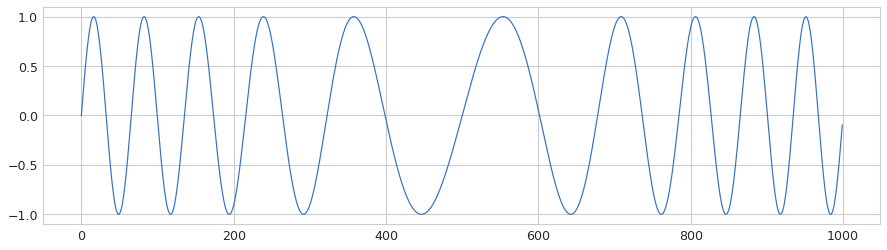

M=10000
Signal Length M=10000


In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
torch.set_num_threads(4)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:4'

fs = 100000 # sampling frequency, Hz
fc = 1000  # carrier frequency, Hz
fm = 100   # modulation frequency, Hz
T = 1. # seconds
twopi = 2*np.pi
t = np.linspace(0, T, int(T*fs), endpoint=False) # time variable
# Produce ramp from 0 to 1
beta = np.linspace(0, 6., int(T*fs)) # increase by two's for slower
signal = np.sin(twopi*fc*t + beta*np.sin(twopi*fm*t))[-10000:]
FREERUN  = 0
plt.figure(figsize=(15,4))
plt.plot(signal[:1000])
plt.show()

M = signal.shape[0]-FREERUN
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 500
REG = 1e-8
TRAINLENGTH = M-TEST
print(f'M={M}')
MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
print(f'Signal Length M={M}')

In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [3]:
import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)

In [4]:
fpath = 'Dicts/S4/diag_S4_long.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts/S4/models_S4_long.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

In [12]:
#with open('Dicts/diagX.json', 'w') as fp:
#    json.dump(dict_diag, fp, cls=NumpyArrayEncoder)
#with open('Dicts/modelsX.json', 'w') as fp:
#    json.dump(dict_models, fp, cls=NumpyArrayEncoder)

In [5]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

### The predictions below are purely from the refinement process in the paper.  There is no handpicking of models.

In [6]:
size = [1000,800,600,400,300,200,100,50,40,30,28,26,24,22,20,18,16,14,12,10]

N=1000   Error = 0.205 KL-div = 0.121 E*kl=0.025
N=800   Error = 0.19 KL-div = 0.039 E*kl=0.007
N=600   Error = 0.294 KL-div = 0.132 E*kl=0.039
N=400   Error = 0.246 KL-div = 0.067 E*kl=0.017
N=300   Error = 0.231 KL-div = 0.089 E*kl=0.021
N=200   Error = 0.298 KL-div = 0.068 E*kl=0.020
N=100   Error = 0.29 KL-div = 0.159 E*kl=0.046
N=50   Error = 0.297 KL-div = 0.098 E*kl=0.029
No model
N=40   Error = 0.297 KL-div = 0.098 E*kl=0.029
No model
N=30   Error = 0.297 KL-div = 0.098 E*kl=0.029
No model
N=28   Error = 0.297 KL-div = 0.098 E*kl=0.029
No model
N=26   Error = 0.297 KL-div = 0.098 E*kl=0.029
No model
N=24   Error = 0.297 KL-div = 0.098 E*kl=0.029
No model
N=22   Error = 0.297 KL-div = 0.098 E*kl=0.029
No model
N=20   Error = 0.297 KL-div = 0.098 E*kl=0.029
No model
N=18   Error = 0.297 KL-div = 0.098 E*kl=0.029
No model
N=16   Error = 0.297 KL-div = 0.098 E*kl=0.029
No model
N=14   Error = 0.297 KL-div = 0.098 E*kl=0.029
No model
N=12   Error = 0.297 KL-div = 0.098 E*kl=0.029
No

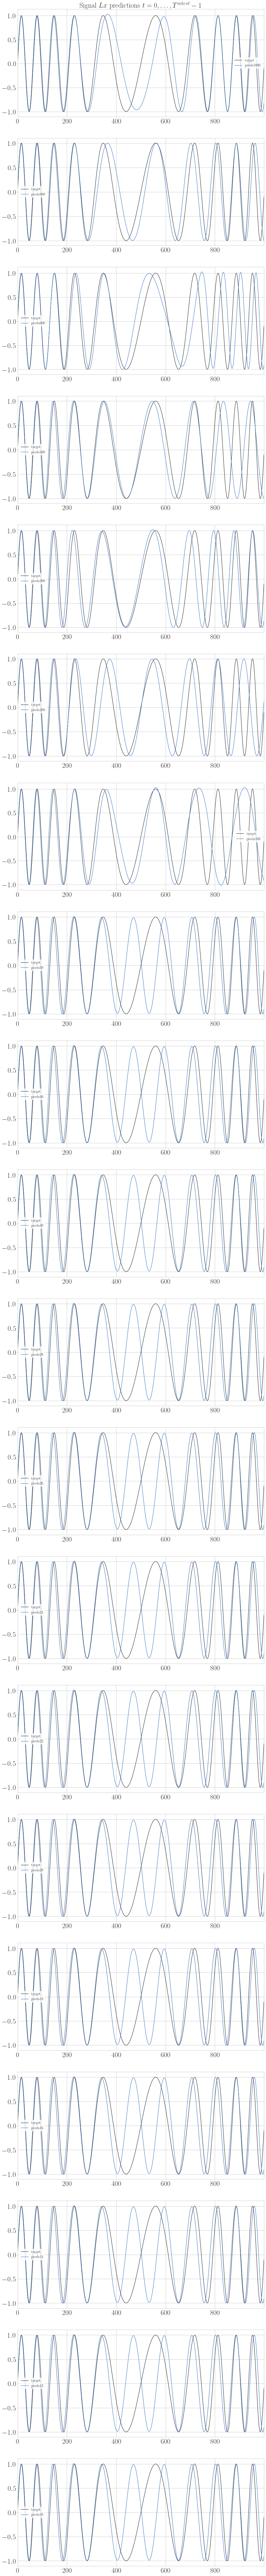

In [8]:
Nplots= len(size)
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
axs[0].set_title('Signal $Lx$ predictions $t=0,\dots,T^{\rm test}-1$')
for n in range(Nplots):
    axs[n].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='k', label='target')
    try:
        preds = dict_models[str(size[n])]['Preds']
    except:
        print('No model')
        pass
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MINMAX)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    Ekl = error_testset*kl
    print(f'N={size[n]}   Error = {error_testset.round(3)} KL-div = {kl:.3f} E*kl={Ekl:.3f}')
    axs[n].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
             color='b', label=f'preds{size[n]}')
    axs[n].legend()
plt.show()

### Get indicated rank to reduce to

Targeted reduced rank for N=1000 is 76
Value v= 19 Tolerance 1e-19 Rho A 0.882
Alpha 0.22889582454300594 --- Gamma 1.0

Targeted reduced rank for N=800 is 74
Value v= 18 Tolerance 1e-18 Rho A 0.888
Alpha 0.24093358305769325 --- Gamma 1.0

Targeted reduced rank for N=600 is 65
Value v= 17 Tolerance 1e-17 Rho A 0.884
Alpha 0.21592482863945195 --- Gamma 1.0

Targeted reduced rank for N=400 is 79
Value v= 19 Tolerance 1e-19 Rho A 0.891
Alpha 0.22878817636547105 --- Gamma 1.0

Targeted reduced rank for N=300 is 80
Value v= 18 Tolerance 1e-18 Rho A 0.907
Alpha 0.20059996790458534 --- Gamma 1.0

Targeted reduced rank for N=200 is 69
Value v= 18 Tolerance 1e-18 Rho A 0.887
Alpha 0.22834073704923732 --- Gamma 1.0

Targeted reduced rank for N=100 is 61
Value v= 18 Tolerance 1e-18 Rho A 0.888
Alpha 0.24093358305769325 --- Gamma 1.0

Targeted reduced rank for N=50 is 39
Value v= 17 Tolerance 1e-17 Rho A 0.891
Alpha 0.22632370996195147 --- Gamma 1.0



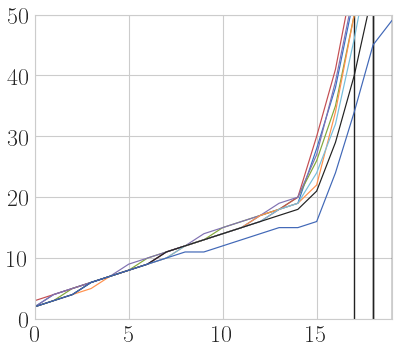

In [10]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

all_ranks = []
K = 1
L = 1
tols = [1/10**x for x in range(0,20)]
np.zeros(len(size),)
plt.figure()
for n in size[:]:
    try:
        dict_diag[str(n)]['numModels']
    except:
        all_ranks.append(0)
        continue
    if(dict_diag[str(n)]['numModels']==0):
        all_ranks.append(0)
        continue
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    grads = np.gradient(rkc)
    v = np.argmax(grads)
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50, color='k')
    if(v+1 == 20):
        ave_rank = (rkc[v]+rkc[v-1])//2
    else:
        ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Targeted reduced rank for N={n} is {ave_rank}\nValue v= {v} Tolerance {tols[v]} Rho A {rhoA.round(3)}')
    print(f'Alpha {a} --- Gamma {g}\n')
    all_ranks.append(ave_rank)
plt.ylim(0,50)
plt.show()



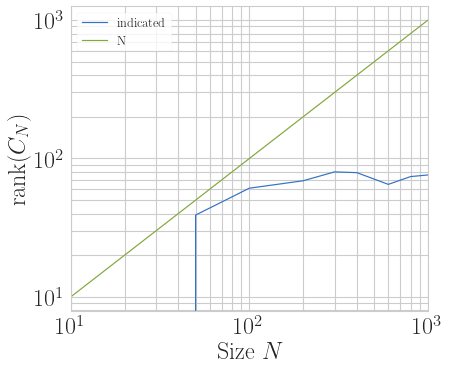

In [12]:
rsize = size[::-1]

plt.loglog(rsize[:],all_ranks[::-1], label='indicated')
plt.loglog(rsize[:],rsize[:], label='N')
plt.xlabel('Size $N$')
plt.ylabel('$\mathrm{rank}(C_N)$')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

In [12]:
mean_error = []
for i in size:
    err = dict_diag[str(i)]['meanError']
    mean_error.append(err)
    print(f'N={i}   number {err}')

N=1000   number 0.15002868829551452
N=800   number 0.14655470159246667
N=600   number 0.14982190768603554
N=400   number 0.1547576321273375
N=300   number 0.14778679241106682
N=200   number 0.1585659881423786
N=100   number 0.17243509627425624
N=50   number 0.17036370980299903
N=40   number 0.18146314993256138
N=30   number 0.17947246674583264
N=28   number 0.19394947849686756
N=26   number 0.1867084515084068
N=24   number 0.1825860848850051
N=22   number 0.1976007393307897
N=20   number 0.19628596521437422
N=18   number 0.2081535451683
N=16   number 0.2093913810608862
N=14   number 0.20909232542036973
N=12   number 0.2202790143973174
N=10   number 0.21803596800315964


### Get time-step of divergence as measured by $R_{\mathbf{xy}}[k]$ correlation at each $t$

In [16]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))
T = M + FREERUN
Nsizes = len(size)
correlations = np.zeros((Nsizes,T))
thresholds = np.zeros(Nsizes)
threshold_location = np.zeros(Nsizes, dtype=int)
for i in range(Nsizes): 
    k = 40
    corr_length = T-k # calculate for j= 0,..., M-k
    try:
        pred = np.array(dict_models[str(size[i])]['Preds']) # Get size N predictions
    except:
        continue
    for j in range(corr_length):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        correlations[i,j] = Rxy(tar,prd)

    minVal = correlations[i,BURNIN:TRAINLENGTH].min()
    thresholds[i] = minVal*.95
    threshold_location[i] = np.where(correlations[i,TRAINLENGTH:]<thresholds[i])[0][0]
    print(f'k=N={k} Trainingset min={minVal.round(3)}  threshold={thresholds[i]:.3f}',
          f' Location={threshold_location[i]}')

k=N=40 Trainingset min=0.992  threshold=0.943  Location=282
k=N=40 Trainingset min=0.992  threshold=0.942  Location=280
k=N=40 Trainingset min=0.993  threshold=0.943  Location=182
k=N=40 Trainingset min=0.992  threshold=0.942  Location=88
k=N=40 Trainingset min=0.992  threshold=0.942  Location=90
k=N=40 Trainingset min=0.993  threshold=0.943  Location=94
k=N=40 Trainingset min=0.991  threshold=0.942  Location=87
k=N=40 Trainingset min=0.991  threshold=0.941  Location=84


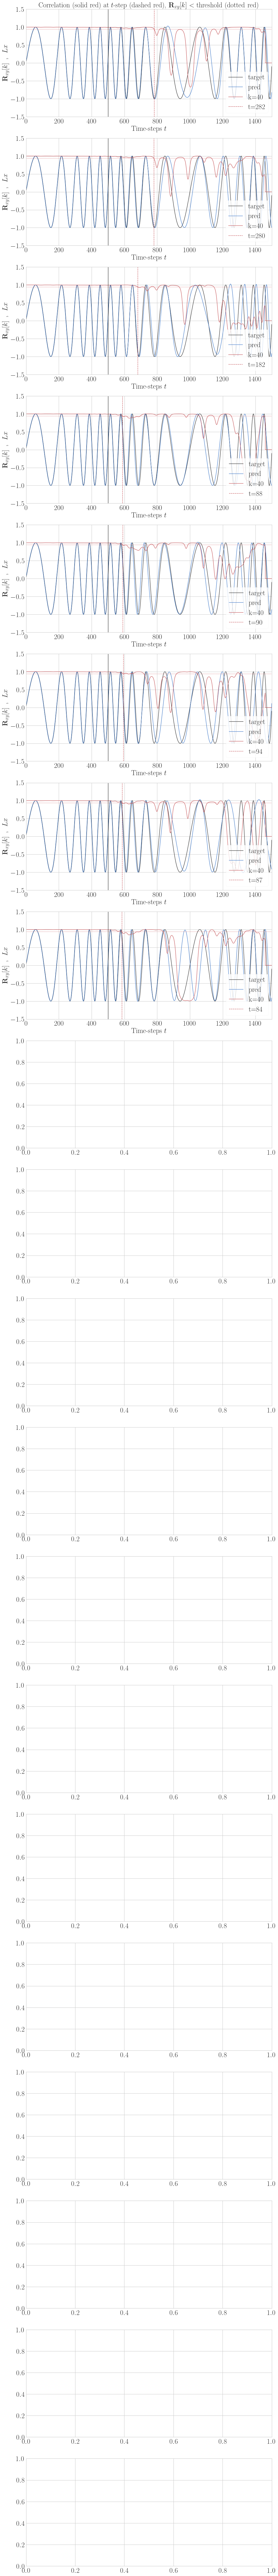

In [20]:
mx = np.max(np.abs(signal))
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
for n in range(Nsizes):
    try:
        pred = dict_models[str(size[n])]['Preds']
    except:
        continue
    axs[n].set_ylim(-1.5,1.5)
    axs[n].plot(signal[8500:TRAINLENGTH+TEST]/mx, color='k', label='target')
    axs[n].plot(pred[8500:TRAINLENGTH+TEST]/mx,color='b', label='pred')
    axs[n].plot(correlations[n,8500:TRAINLENGTH+TEST], color='r', label=f'k={k}')
    axs[n].axvline(500+threshold_location[n],color='r', linestyle='dashed', label=f't={threshold_location[n]}')
    axs[n].axvline(500,color='k')
    axs[n].axhline(thresholds[n],color='r', linestyle='dotted')
    axs[n].set_ylabel('$\mathbf{R}_{xy}[k]\enspace ,\enspace Lx$')
    axs[n].set_xlabel('Time-steps $t$')
    axs[n].legend(fontsize=24,loc='lower right')
axs[0].set_title('Correlation (solid red) at $t$-step (dashed red), $\mathbf{R}_{xy}[k]<\mathrm{threshold}$ (dotted red) ')
plt.show()